In [57]:
import gym
from gym import spaces

import random
import scipy
import numpy as np
import pandas as pd

import stable_baselines3
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

In [58]:
#Function for normal distribution truncation:

from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [59]:
#Function to get date sequence based on start_date and num_of_weeks:

def get_date_seq(start_date_arr, num_of_weeks_arr): #start_date index 2, num_of_weeks index 3
    date_seq_arr = np.empty(shape=(len(start_date_arr),), dtype='object')
    for i in range(len(date_seq_arr)):
        date_seq_arr[i] = list(range(int(start_date_arr[i]), int(start_date_arr[i]) + int(num_of_weeks_arr[i])*7, 7))
    return date_seq_arr

In [60]:
#Function to get observation (still for single env, need to modify for multi-agent env):

def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

In [61]:
#Function to get the one-hot-encoded vectors for departure and arrival airports:

def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

# Example usage
num_airports = 3
airport1 = 0
airport2 = 1
airport3 = 2

encoded_airport1 = one_hot_encode_airport(airport1, num_airports)
encoded_airport2 = one_hot_encode_airport(airport2, num_airports)
encoded_airport3 = one_hot_encode_airport(airport3, num_airports)

print(encoded_airport1)
print(encoded_airport2)
print(encoded_airport3)

[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [62]:
#Generate full info for the arrival sides:

def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    start_date_arv = np.empty(shape=(len(requests),), dtype='object')
    #date_seq_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][7]/5
        if ts_arv[i] > 287:
            ts_arv[i] = ts_arv[i] - 287
            start_date_arv[i] = requests[i][2] + 1
        else:
            start_date_arv[i] = requests[i][2]
    date_seq_arv = get_date_seq(start_date_arv, requests[:, 3])
    return ts_arv, start_date_arv, date_seq_arv

In [136]:
#Generate the multi-agent scenario:

#=======================================================

#Modify the distribution based on historical data later:
def generate_scenario(number_of_requests, num_airports, cap_dict):
    
    #number_of_requests = 15000
    ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate start date:

    start_date_dep = np.random.randint(low = 0, high=146, size=number_of_requests) #146 because period is 182 days and we consider series which span at least 5 weeks (+35 days)

    #Generate number of weeks:

    _max_day = np.full(number_of_requests, 182 - 1)

    _remaining_days = _max_day - start_date_dep

    _max_num_of_weeks = _remaining_days // 7

    num_of_weeks = np.random.randint(5, _max_num_of_weeks + 1)

    #Generate index for requests:

    index = np.array(list(range(number_of_requests)))

    #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):

    #num_airports = 3
    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    destination_airport = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range(number_of_requests):
        _org_airport = one_hot_encode_airport(random.randint(0,2), num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
        #Generate destination (the destination will be different with the origin):
        _dest_airport = _org_airport.copy()
        while np.array_equal(_dest_airport, _org_airport):
            np.random.shuffle(_dest_airport)
        _dest_airport_list = _dest_airport.tolist()
        destination_airport[i] = _dest_airport_list

    #Generate flying time (assume between airport 0 and 1 is 2 hour, 0 to 2 and 1 to 2 is arbitrary):

    fly_time = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range (number_of_requests):
        if origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])

    #Get date sequence (date seq is actually a list):

    date_seq_dep = get_date_seq(start_date_dep, num_of_weeks)

    #Generate status cap:

    status_cap_dep = np.full((number_of_requests,), 0)
    status_cap_arv = np.full((number_of_requests,), 0)
    

    requests = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep), axis=1)

    #Generate full info for the arv side:

    ts_arv, start_date_arv, date_seq_arv = generate_info_arv(requests)

    #pseudo_belong_dep = np.full((number_of_requests,), 0)
    #pseudo_belong_arv = np.full((number_of_requests,), 0)
    
    # Define requests_full as dtype object
    # requests_full = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv), axis=1)
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 13), dtype=object)
    # Fill the array
    data = [index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    airport_req_dict, _belong_airport_dict = get_airport_req_dict(requests_full, num_airports)

    pot_dem_dict = get_initial_pot_dem_per_airport(airport_req_dict, num_airports)

    cap_dem_dict = get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict)

    return requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict

    #Generate capacity:

    #cap_arr = np.full((288, 182), 20)

    #Create final_sched:

    #final_sched_arr = req_arr.copy()

    #Get potential demand: #Check again the function here (turn to array)
    #pot_dem_arr = get_initial_pot_dem()

    #Get remaining cap:
    #cap_dem_arr = cap_arr - pot_dem_arr

In [64]:
def get_violate_id_set(airport_req_dict, num_airports):
    violate_set = [] #(1: id, 2: airport, 3: dep, 4: arv)
    for i in range(num_airports):
        mask = ((airport_req_dict['req_{}'.format(i)][:, 8] + airport_req_dict['req_{}'.format(i)][:, 12]) >= 1)
        _id_violate_per_airport = airport_req_dict['req_{}'.format(i)][mask, :][:,0]
        violate_set.append(_id_violate_per_airport)
    violate_set = np.concatenate(violate_set, axis=0)
    violate_set = np.unique(violate_set)
    return violate_set

In [65]:
def get_violate_id_set_req_full(requests_full):
    mask = ((requests_full[:, 8] + requests_full[:, 12]) >= 1)
    violate_set_req_full = requests_full[mask, :][:,0]
    return violate_set_req_full

In [66]:
def get_req(violate_set, requests_full):
    _violate_index = random.choice(violate_set)
    chosen_req = requests_full[requests_full[:,0] == _violate_index]
    return chosen_req

In [67]:
def flatten_cap_dem_dict(cap_dem_dict, num_airports):
    cap_dem_dict_flat = {}
    for i in range(num_airports):
        cap_dem_dict_flat['req_{}'.format(i)] = cap_dem_dict['req_{}'.format(i)].flatten()
    return cap_dem_dict_flat

In [69]:
#Get separated req per airport and store in a dict:

def get_airport_req_dict(requests_full, num_airports):
    airport_req_dict = {}
    _belong_airport_dict = {}
    for i in range(num_airports):
        airport_req_dict['req_{}'.format(i)] = np.empty((0, 15)) #This one depends on the number of elements of a final request
        _belong_airport_dict['req_{}'.format(i)] = np.full(num_airports, 0.0, dtype=float)
        _belong_airport_dict['req_{}'.format(i)][i] = float(1.0)
        _belong_airport_dict['req_{}'.format(i)] = _belong_airport_dict['req_{}'.format(i)].tolist()
        
    for i in range(len(requests_full)):
        _found_dep = 0
        _found_arv = 0
        for k in range(num_airports):
            #_found_dep = 0
            #_found_arv = 0
            if requests_full[i][5] == _belong_airport_dict['req_{}'.format(k)]:
                _dep_req = np.append(requests_full[i], 1)
                _dep_req = np.append(_dep_req, 0)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _dep_req))
                _found_dep = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #break
            if requests_full[i][6] == _belong_airport_dict['req_{}'.format(k)]:
                _arv_req = np.append(requests_full[i], 0)
                _arv_req = np.append(_arv_req, 1)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _arv_req))
                _found_arv = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #break
            if _found_dep + _found_arv == 2:
                break
        if _found_dep + _found_arv != 2:
            print("Cannot found both dep and arv at req {}".format(i))
            
    return airport_req_dict, _belong_airport_dict

In [70]:
def generate_deterministic_capacity_dict(num_airports, cap_per_airport_arr): #This function is for a period of 182 days and 288 slots/ day
    cap_dict = {}
    for i in range(num_airports):
        cap_dict['req_{}'.format(i)] = np.full((288, 182), cap_per_airport_arr[i])
    return cap_dict

In [71]:
def get_initial_pot_dem_per_airport(airport_req_dict, num_airports): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_dict = {}
    #TODO: increase speed
    #13 dep 14 arv, 1 dep ts, 9 arv ts
    for i in range(num_airports):
        pot_dem_dict['req_{}'.format(i)] = np.full((288, 182), 0)
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            pot_dem_dict['req_{}'.format(i)][_time_slot, _date_seq] += 1
    return pot_dem_dict

In [72]:
def get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict):
    cap_dem_dict = {}
    for i in range(num_airports):
        cap_dem_dict['req_{}'.format(i)] = cap_dict['req_{}'.format(i)] - pot_dem_dict['req_{}'.format(i)]
    return cap_dem_dict

In [73]:
def update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
    for i in range(num_airports):
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            if all(x >= 0 for x in cap_dem_dict['req_{}'.format(i)][_time_slot, _date_seq]):
                #print(self.cap_dem_arr[_time_slot, _date_seq])
                airport_req_dict['req_{}'.format(i)][k][8] = 0
                airport_req_dict['req_{}'.format(i)][k][12] = 0
            else:
                if airport_req_dict['req_{}'.format(i)][k][13] == 1:
                    airport_req_dict['req_{}'.format(i)][k][8] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 8] = 1
                else:
                    airport_req_dict['req_{}'.format(i)][k][12] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 12] = 1

In [202]:
class TwoAirportSchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_requests, num_airports, cap_per_airport_arr):
        
        super(TwoAirportSchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions)
        self.do_nothing_action = int((self.number_of_actions - 1)/2)
        self.number_of_requests = number_of_requests
        self.num_airports = num_airports
        #self.number_of_days = number_of_days
        self.cap_per_airport_arr = cap_per_airport_arr
        self.cap_dict = generate_deterministic_capacity_dict(self.num_airports, self.cap_per_airport_arr)
        #self.generate_scenario()
        #update the code to add generate scenario 
        self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests, num_airports, cap_dict = self.cap_dict)
        #to generate action:
        self.action_space = spaces.Discrete(self.number_of_actions)

        #cap_dem_dict_flat = flatten_cap_dem_dict(cap_dem_dict, num_airports)
        #_generate = True
        _exceed_cap = 0         
        while _exceed_cap == 0:
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests = self.number_of_requests, num_airports = self.num_airports, cap_dict = self.cap_dict)
            self.cap_dem_dict_flat = flatten_cap_dem_dict(self.cap_dem_dict, self.num_airports)
            for i in range(num_airports):
                _exceed_cap = _exceed_cap + (min(self.cap_dem_dict_flat['req_{}'.format(i)]))
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.num_step = 0

        self.chosen_req = random.choice(self.requests_full)
    
    #added get request to know which is the request we are going to move at this step",
    # def get_req(self):
    #     violate_set=get_violate_id_set(self.airport_req_dict, num_airports)
    #     _violate_index = random.choice(violate_set)
    #     self.chosen_req = self.requests_full[self.requests_full[:,0] == _violate_index]
    
    #need to check arrival time or change the variable to check_outbound(arv) and chec_outbound(dep)
    def check_outbound(self, action):
        dep_time_slot = self.chosen_req[1]
        arv_time_slot = self.chosen_req[9]
        change_slot = action - self.do_nothing_action

        outbound = False

        new_dep_time_slot = dep_time_slot + change_slot
        new_arv_time_slot = arv_time_slot + change_slot

        if (new_dep_time_slot < 0) or (new_dep_time_slot > 287) or (new_arv_time_slot < 0) or (new_arv_time_slot > 287):
            outbound = True

        return outbound
    
    def dep_or_arv(self):
        pass

    def update_dem(self, dep_airport, arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, date_seq_dep, date_seq_arv):
        # Increment demand for the new time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][new_time_slot_dep, date_seq_dep] += 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][new_time_slot_arv, date_seq_arv] += 1

        # Decrease demand for the initial time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][time_slot_dep, date_seq_dep] -= 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][time_slot_arv, date_seq_arv] -= 1

    def update_cap_dem(self):
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            if cap_key not in self.cap_dict:
                raise KeyError(f"'{cap_key}' not found in cap_dict. Available keys: {list(self.cap_dict.keys())}")
            self.cap_dem_dict[cap_key] = self.cap_dict[cap_key] - self.pot_dem_dict[dem_key]

    def update_violate_set(curr_violate, not_violate_update, violate_update):
        curr_violate = set(curr_violate)
        for req_index in not_violate_update:
            curr_violate.remove(req_index)
        for req_index in violate_update:
            curr_violate.add(req_index) 
        curr_violate = list(curr_violate)
        return curr_violate 
    
    def step(self, action):
        _index = self.chosen_req[0]
        time_slot_dep = self.chosen_req[1]
        time_slot_arv = self.chosen_req[9]
        time_slot_arv = int(time_slot_arv)
        change_slot = action - self.do_nothing_action
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        _date_seq_dep = self.chosen_req[4]
        _date_seq_arv = self.chosen_req[11]
        _start_date_dep = self.chosen_req[2]
        _start_date_arv = self.chosen_req[10]
        _num_weeks = self.chosen_req[3]
        new_time_slot_dep = time_slot_dep + change_slot
        new_time_slot_arv = time_slot_arv + change_slot
        new_time_slot_arv = int(new_time_slot_arv)
        new_date_seq_dep = _date_seq_dep
        new_date_seq_arv = _date_seq_arv

        outbound = self.check_outbound(action)

        if not outbound:
            pass
            
        elif outbound:
            # Adjust the departure time slot as needed
            if new_time_slot_dep < 0:
                new_time_slot_dep = 287  # Move to the last time slot of the previous day
                new_start_date_dep = _start_date_dep - 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            elif new_time_slot_dep > 287:
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_start_date_dep = _start_date_dep + 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            # Adjust the departure time slot as needed
            if new_time_slot_arv < 0:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_arv = 287  # Move to the last time slot of the previous day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv - 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)
            elif new_time_slot_dep > 287:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv + 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)

        else:
            print('Problem with check outbound!')
            #update airport_req_dict
            #update dem_dict all
            #update cap_dem all
            #update status all
            
        # Update the request for both departure and arrival time slots and dates
        self.requests_full[self.requests_full[:, 0] == _index][:, 1] = new_time_slot_dep
        self.requests_full[self.requests_full[:, 0] == _index][:, 9] = new_time_slot_arv
        # self.requests_full[self.requests_full[:, 0] == _index][:, 4] = new_date_seq_dep
        # self.requests_full[self.requests_full[:, 0] == _index][:, 11] = new_date_seq_arv
        _index_matching = np.where(self.requests_full[:, 0] == _index)[0][0]
        self.requests_full[_index_matching, 4] = new_date_seq_dep
        self.requests_full[_index_matching, 11] = new_date_seq_arv

        # Update the airport request dict
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 9] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 1] = new_time_slot_arv
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 9] = new_time_slot_arv

        # Update demand for the new time slots
        self.update_dem(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, new_date_seq_dep, new_date_seq_arv)
        
        # Update cap_dem 
        self.update_cap_dem()

        # Update status capacity after the cap_dem table is updated
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.chosen_req)

        # Reward part:
        local_reward = 0
        if outbound:
            local_reward = -1
        else:
            local_reward = 0.1*(-abs(change_slot)*0.5*_num_weeks) #TODO change if increase number of actions
        
        self.num_step += 1
        done = False

        if self.chosen_req[8] == 0 and self.chosen_req[12] == 0:
            done = True
            obs = np.zeros((self.number_of_actions + 1,))
            global_reward = 100

        elif self.num_step == self.number_of_requests*5:
            done = True
            obs = np.zeros((self.number_of_actions + 1,))
            negative_sum = 500
            for value in self.cap_dem_dict.values():
                # Assuming each value is a numeric value or a numpy array
                # If it's a numpy array, you can sum all negative values directly using numpy
                if isinstance(value, np.ndarray):
                    negative_sum += np.sum(value[value < 0])
                else:
                    # If it's a single numeric value, just check if it's negative
                    if value < 0:
                        negative_sum += value
            global_reward = negative_sum*10

        else:
            global_reward = 0
            obs = self._next_observation()

        reward_time_step = -0.5
            
        total_reward = float(local_reward + global_reward + reward_time_step)
    
        return obs, total_reward, done, {}

    def take_action(self):

        # Use it like this:
        # env = TwoAirportSchedEnv(...)
        # env.take_action()
        # Step 1: Randomly choose actions
        action_dep = self.action_space.sample()  # For the departure airport
        action_arv = self.action_space.sample()  # For the arrival airport

        #Step 2: Check if actions match
        # matched_action = None
        matched_action = action_dep
        if action_dep == action_arv:
            matched_action = action_dep

        return matched_action

    # Implement next_observation

    # Implement reset


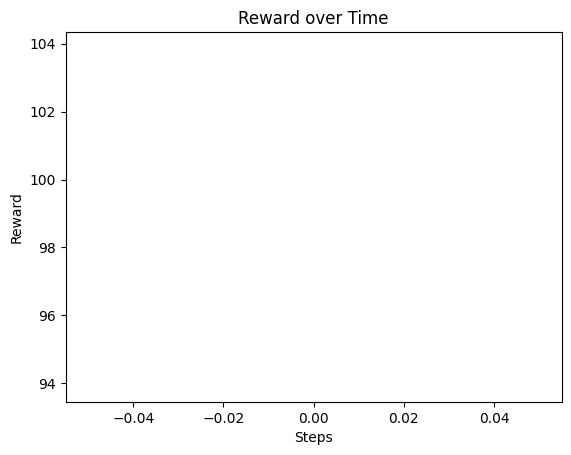

In [209]:
import matplotlib.pyplot as plt

def test_simulator():
    # 1. Initialization
    num_actions = 10
    num_requests = 20
    num_airports = 3
    cap_per_airport = [10, 12, 14]  # Example capacities
    env = TwoAirportSchedEnv(num_actions, num_requests, num_airports, cap_per_airport)

    # Number of steps you want to test the simulator for
    num_steps = 100
    rewards = []

    for _ in range(num_steps):
        # 2. Reset the environment
        # obs = env.reset()
        # 3. Take steps
        action = env.take_action()
        next_obs, reward, done, info = env.step(action)
        rewards.append(reward)
        
        if done:
            break

    # 4. Visualize Results
    plt.plot(rewards)
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.title("Reward over Time")
    plt.show()

# Call the test function
test_simulator()

In [ ]:
TwoAirportSchedEnv_agent1 = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])
TwoAirportSchedEnv_agent2 = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])
TwoAirportSchedEnv_agent1.reset()
TwoAirportSchedEnv_agent2.reset()


for ep in range(10):
    TwoAirportSchedEnv_agent1.reset()
    TwoAirportSchedEnv_agent2.reset()
    done = False
    action_list = []
    index_list = []
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Episode", ep)
    print("Initial req", env.final_sched_arr)
    print("Obs is", env.obs)
    print("Obs type", type(env.obs))
    while not done:
        same_action = False
        while not same_action:
            action1 = TwoAirportSchedEnv_agent1.action_space.sample()
            action2 = TwoAirportSchedEnv_agent2.action_space.sample()
            if action1 == action2:
                same_action =  True
                action = action1
        #change the env for both agents 
        for env in [TwoAirportSchedEnv_agent1,TwoAirportSchedEnv_agent2]:
            #action, _states = model.predict(obs)
            action_list.append(action - 2)
            #print(type(action))
            #obs, reward, done, info = env.step(action)
            index_list.append(env.chosen_req_arr[1])
            print("Action is:", action)
            #print("Remaining req is:", env.req_df_update)
            print("Chosen req is:\n", env.chosen_req_arr)
            print("Obs is:\n", obs)
            #print("Pot dem:\n", env.pot_dem_df)
            print("Cap dem:\n", env.cap_dem_arr)
            obs, reward, done, info = env.step(action)

In [ ]:
#Not done
def next_observation(self):
    _chosen_req_info = self.chosen_req
    
    _dep_time_slot = self.chosen_req[:,1]
    _num_of_weeks = self.chosen_req[:,3]
    _dep_date_seq = self.chosen_req[:,4]
    _dep_belong = self.chosen_req[:,5][0]
    
    _arv_time_slot = self.chosen_req[:,9]
    _arv_date_seq = self.chosen_req[:,11]
    _arv_belong = self.chosen_req[:,6][0]

    _cap_dem_dep = self.cap_dem_arr[:, _date_seq].copy()
    _cap_dem_arv = self.cap_dem
    #print(self.number_of_actions, type(self.number_of_actions))
    _obs_min_arr = full_obs(_cap_dem_chosen_req, self.number_of_actions)
    _obs_time_slot_related = list(range(_time_slot, _time_slot + self.number_of_actions, 1))
    _cap_dem_obs = _obs_min_arr[_obs_time_slot_related]    

In [ ]:
#Setting 1 (each involving agent (arr/dep) takes action independently -> lead to ):
def take_action_jointly(self):
    pass        

In [ ]:
def check_outbound(chosen_req, action): #Havent modified
    _time_slot = self.chosen_req_arr[1]
    if ((_time_slot + (action - self.do_nothing_action)) < 0) or ((_time_slot + (action - self.do_nothing_action)) > 287):
        outbound = True
    else:
        outbound = False
    #print('Time slot:\n', _id)
    #print('Action:\n', action)
    #print('Outbound:\n', outbound)
    return outbound

In [ ]:
TwoAirportSchedEnv = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])

In [ ]:
requests_full = TwoAirportSchedEnv.requests_full
airport_req_dict = TwoAirportSchedEnv.airport_req_dict
_belong_airport_dict = TwoAirportSchedEnv._belong_airport_dict
pot_dem_dict = TwoAirportSchedEnv.pot_dem_dict

In [ ]:
cap_dict = TwoAirportSchedEnv.cap_dict

In [ ]:
cap_dem_dict = get_cap_dem_dict(3, cap_dict, pot_dem_dict)
cap_dem_dict

In [ ]:
_belong_airport_dict

In [ ]:
_dep_belong = chosen_req[:,5][0]
_dep_belong

In [ ]:
def getKey(dct,value):
     return [key for key in dct if (dct[key] == value)]

In [ ]:
dep_key = getKey(_belong_airport_dict, _dep_belong)
dep_key

In [ ]:
_obs_time_slot_related = list(range(_dep_time_slot[0] - 2, _dep_time_slot[0] + 2, 1)) #5 is number of actions
_obs_time_slot_related

In [ ]:
_dep_date_seq = chosen_req[:,4]
_dep_date_seq

In [ ]:
#Havent modified
def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

In [ ]:
violate_id = get_violate_id_set(airport_req_dict, 3)

In [ ]:
violate_req = get_violate_id_set_req_full(requests_full)

In [ ]:
len(violate_id)

In [ ]:
len(violate_req)

In [ ]:
violate_id

In [ ]:
violate_req

In [ ]:
#Check if airport req dict generated correctly:
a = TwoAirportSchedEnv.airport_req_dict['req_0'][:,0]
b = TwoAirportSchedEnv.airport_req_dict['req_1'][:,0]
c = TwoAirportSchedEnv.airport_req_dict['req_2'][:,0]
ab = np.intersect1d(a,b)
bc = np.intersect1d(b,c)
ca = np.intersect1d(c,a)
len(a) + len(b) + len(c) - len(ab) - len(bc) - len(ca)

In [ ]:
def get_req(violate_set, requests_full): 
    _violate_index = random.choice(violate_set)
    chosen_req = requests_full[requests_full[:,0] == _violate_index]
    return chosen_req

In [ ]:
def check_random_n_violate_req(n, violate_set, requests_full): #violate_set <- violate_id or violate_req
    for i in range(n):
        _chosen_req = get_req(violate_set, requests_full)
        if _chosen_req[:,8] + _chosen_req[:,12] == 0:
            print('There is error at req {}'.format(_chosen_req))
    print('Check {} violated reqs done!'.format(n))

In [ ]:
violate_set = get_violate_id_set(TwoAirportSchedEnv.airport_req_dict, TwoAirportSchedEnv.num_airports)

In [ ]:
check_random_n_violate_req(100, violate_set, requests_full)

In [ ]:
def check_violate_set(violate_set, airport_req_dict, ): #TODO
    pass

In [ ]:
check_request(TwoAirportSchedEnv.requests_full, TwoAirportSchedEnv.airport_req_dict, TwoAirportSchedEnv._belong_airport_dict, TwoAirportSchedEnv.num_airports, TwoAirportSchedEnv.pot_dem_dict)

In [ ]:
def check_union_req_per_airport(airport_req_dict, num_airports, num_requests):
    pass
#Written above, hasnt writtern in terms of function 

In [ ]:
def check_pot_dem_dict(airport_req_dict, num_airports, pot_dem_dict):
    for i in range(num_airports):
        if sum(airport_req_dict['req_{}'.format(i)][:,3]) == sum(sum(pot_dem_dict['req_{}'.format(i)])):
            print('req {} checked. No issue!'.format(i))
        else:
            print('req {} has problem!'. format(i))

In [ ]:
#Functions to check the generated scenarios:

def check_exceed_period(requests_full):
    for i in range(len(requests_full)):
        if max(requests_full[i][4]) >= 182:
            print('Exceed period departure at request {}'.format(i))
        if max(requests_full[i][11]) >= 182:
            print('Exceed period arrival at request {}'.format(i))
    print('Check exceed period done!')

    
def check_if_same_org_dest(requests):
    for i in range(len(requests)):
        if requests[i][5] == requests[i][6]:
            print('Problem at {}'.format(i))
#         else:
#             print(i, 'Checked')
    print('Check if any same origin and destination done!')
    
    
def check_correspond_time_slot(requests):
    for i in range(len(requests)):
        if requests[i][1] + requests[i][7]/5 > 287:
            #print(i, '1')
            _ts_arv = (requests[i][1] + requests[i][7]/5) - 287
            if requests[i][9] != _ts_arv:
                print("Not corresponding time slot at request {}".format(i))
        else:
            #print(i, '2')
            if requests[i][9] != requests[i][1] + requests[i][7]/5:
                print("Not corresponding time slot at request {}".format(i))
    print('Check corresponding time slot done!')
    
    
def check_correspond_date(requests):
    for i in range(len(requests)):
        if requests[i][1] + requests[i][7]/5 > 287:
            #print(i, '1')
            _start_date_arv = requests[i][2] + 1
            if requests[i][10] != _start_date_arv:
                print("Not corresponding start date at request {}".format(i))
        else:
            #print(i, '2')
            if requests[i][10] != requests[i][2]:
                print("Not corresponding start date at request {}".format(i))
    print("Check start date done!")
    
    
def check_date_seq(requests):
    for i in range(len(requests)):
        if requests[i][1] + requests[i][7]/5 > 287:
            #print(i, '1')
            _date_seq_arv = [x+1 for x in requests[i][4]]
            if requests[i][11] != _date_seq_arv:
                print('Not corresponding date seq at request {}'.format(i))
        else:
            #print(i, '2')
            if requests[i][11] != requests[i][4]:
                print('Not corresponding date seq at request {}'.format(i)) 
    print('Check date seq done!')
    
    
def check_duplication_each_req_airport(airport_req_dict, num_airports):
    for i in range(num_airports):
        if len(airport_req_dict['req_{}'.format(i)]) != len(list(set(airport_req_dict['req_{}'.format(i)][:,0]))):
            print('Duplication at airport {}'.format(i))
    print('Check duplication per airport req done!')
    
    
def check_correct_dep_arv_binary_values(airport_req_dict, _belong_airport_dict, num_airports):
    for i in range(num_airports):
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            if airport_req_dict['req_{}'.format(i)][k][5] == _belong_airport_dict['req_{}'.format(i)] and airport_req_dict['req_{}'.format(i)][k][13] != 1:
                print('Not correct dep at airport {} and req {}!'.format(i, k))
            if airport_req_dict['req_{}'.format(i)][k][6] == _belong_airport_dict['req_{}'.format(i)] and airport_req_dict['req_{}'.format(i)][k][14] != 1:
                print('Not correct arv at airport {} and req {}!'.format(i, k))
            if airport_req_dict['req_{}'.format(i)][k][5] != _belong_airport_dict['req_{}'.format(i)] and airport_req_dict['req_{}'.format(i)][k][6] != _belong_airport_dict['req_{}'.format(i)]:
                print('Req {} not belong to airport {}'.format(k, i))
                print('====')
                print(airport_req_dict['req_{}'.format(i)][k][5], airport_req_dict['req_{}'.format(i)][k][6], _belong_airport_dict['req_{}'.format(i)])
            if airport_req_dict['req_{}'.format(i)][k][13] + airport_req_dict['req_{}'.format(i)][k][14] != 1:
                print('Not unique in dep and arv status at airport {} and req {}!'.format(i, k))
    print('Check dep and arv status done!')
    

def check_pot_dem_dict(airport_req_dict, num_airports, pot_dem_dict):
    for i in range(num_airports):
        if sum(airport_req_dict['req_{}'.format(i)][:,3]) == sum(sum(pot_dem_dict['req_{}'.format(i)])):
            print('req {} checked. No issue!'.format(i))
        else:
            print('req {} has problem!'. format(i))

    
#==================================================================================
    
    
def check_request(requests_full, airport_req_dict, _belong_airport_dict, num_airports, pot_dem_dict):
    check_if_same_org_dest(requests_full)
    check_correspond_time_slot(requests_full)
    check_correspond_date(requests_full)
    check_date_seq(requests_full)
    check_exceed_period(requests_full)
    
    check_duplication_each_req_airport(airport_req_dict, num_airports)
    check_correct_dep_arv_binary_values(airport_req_dict, _belong_airport_dict, num_airports)
    check_pot_dem_dict(airport_req_dict, num_airports, pot_dem_dict)

In [ ]:
for i in range(100):
    num_airports = 3
    requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict = generate_scenario(number_of_requests = 15000, num_airports = 3, cap_dict = cap_dict)
    check_request(requests_full, airport_req_dict, _belong_airport_dict, num_airports, pot_dem_dict)
    print('{}:======================================='.format(i))

In [ ]:
#Previous single-agent simulator:

class SchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_request, number_of_days):
        
        super(SchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions) #Number of action should be an odd number
        self.do_nothing_action = int((self.number_of_actions - 1)/2)
        self.number_of_request = number_of_request
        self.number_of_days = number_of_days
        self.generate_scenario()
        _cap_dem_flat = self.cap_dem_arr.flatten()
        #Test lai so lan chay while o day, neu ko thi dung pattern (distribution) de chac chan over:
        while min(_cap_dem_flat) >= 0:
            self.generate_scenario()
            _cap_dem_flat = self.cap_dem_arr.flatten()
        self.update_status_capacity
        #Check number of training step:
        self.num_step = 0
        
        
#         #Get remaining cap:
#         self.cap_dem_df = self.cap_df - self.pot_dem_df
        
        #Define action and observation space:
        self.action_space = spaces.Discrete(int(number_of_actions)) #TODO can change later if increase the number of shifting slot
        #self.observation_space = spaces.Box(low= -np.inf, high= np.inf, shape=(5, 11), dtype=np.float)
        self.observation_space = spaces.Box(low= -np.inf, high= np.inf, shape=(self.number_of_actions + 1,), dtype=float)
        

    def generate_scenario(self):
        #Generate requests:
#         number_of_request = 80
#         number_of_days = 14

#         time_slot = list(np.random.randint(low = 0, high=12, size=number_of_request))

#         start_date = list(np.random.randint(low = 0, high=7, size=number_of_request))

#         num_of_weeks = list(np.random.randint(low = 1, high=3, size=number_of_request))
        
    
        #Change parameters here:
#         self.number_of_request = number_of_request
#         self.number_of_days = number_of_days

        #Generate time slot, 2 peak time slots are 72 and 216 (TODO to be changed accordingly later):
        ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(self.number_of_request/2)))
        ts_72 = np.round(ts_72)

        ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(self.number_of_request/2)))
        ts_216 = np.round(ts_216)

        ts_arr = np.concatenate((ts_72, ts_216))
        ts_arr = ts_arr.astype(int)

        #Generate start date:
        start_date_arr = np.random.randint(low = 0, high=6, size=self.number_of_request) #This is only for more than 150 days only
        start_date_arr = start_date_arr*30
        #start_date_arr = np.random.randint(low = 0, high=self.number_of_days, size=self.number_of_request)

        #Generate number of weeks:
        _max_day = np.full(self.number_of_request, self.number_of_days - 1)

        _remaining_days_arr = _max_day - start_date_arr

        _max_num_of_weeks_arr = _remaining_days_arr // 7

        num_of_weeks_arr = np.random.randint(1, _max_num_of_weeks_arr + 2)
        
        #Generate index for requests:
        
        index_arr = np.array(list(range(self.number_of_request)))
        
        #Get date sequence:

        date_seq_arr = get_date_seq(start_date_arr, num_of_weeks_arr)
        
        #Generate status cap:
        
        status_cap_arr = np.full((self.number_of_request,), 0)

        self.req_arr = np.stack((index_arr, ts_arr, start_date_arr, num_of_weeks_arr, date_seq_arr, status_cap_arr), axis=1)
        
        
        #Generate capacity:
        self.cap_arr = np.full((288, self.number_of_days), 20)
        
        
        #Create final_sched:
        self.final_sched_arr = self.req_arr.copy()
        
        #Get potential demand: #Check again the function here (turn to array)
        self.pot_dem_arr = self.get_initial_pot_dem()
        
        #Get remaining cap:
        self.cap_dem_arr = self.cap_arr - self.pot_dem_arr
        
    def get_date_seq(row):
        return(list(range(row['start_date'], row['start_date'] + row['num_of_weeks']*7, 7)))
    
    def check_in_date_seq(row, value):
        if value in row['date_seq']:
            return True
        else:
            return False
    
    def get_initial_pot_dem(self): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
        pot_dem_arr = np.full((288, self.number_of_days), 0)
        #TODO: increase speed
        for i in range(len(self.final_sched_arr)):
            _time_slot = int(self.final_sched_arr[i,1])
            _date_seq = self.final_sched_arr[i,4]
            pot_dem_arr[_time_slot, _date_seq] += 1
        return pot_dem_arr    


    #To be updated:            
    def update_pot_dem(self, action):
        if not self.check_outbound(action):
            if action != self.do_nothing_action:
                _time_slot = self.chosen_req_arr[1]
                _date_seq = self.chosen_req_arr[4]
                self.pot_dem_arr[_time_slot, _date_seq] -= 1
                self.pot_dem_arr[_time_slot + action - self.do_nothing_action, _date_seq] += 1       
            
    def update_status_capacity(self):
        #Them cot cap_status o init:
        for i in range(len(self.final_sched_arr)):
            _time_slot = int(self.final_sched_arr[i,1])
            _date_seq = self.final_sched_arr[i,4]
            if all(x >= 0 for x in self.cap_dem_arr[_time_slot, _date_seq]):
                #print(self.cap_dem_arr[_time_slot, _date_seq])
                self.final_sched_arr[i,5] = 0
            else:
                self.final_sched_arr[i,5] = 1
        
    def get_req(self):
            
        #Them cot status capacity of req trong req_df and update moi khi take action, chu y la con lien quan toi req khac
        _chosen_req = self.final_sched_arr[self.final_sched_arr[:,5] == 1]
        #print(_chosen_req)
        #print(self.final_sched_arr)
        #print(np.unique(env.cap_dem_arr))
        self.chosen_req_arr = random.choice(_chosen_req)
        #return self.chosen_req_arr
           
    def check_outbound(self):
        pass
    
    
    #TODO: change to 288 when changing time slot
    def _take_action(self, action):
        if not self.check_outbound(action):
            self.final_sched_arr[self.chosen_req_arr[0],1] += action - self.do_nothing_action
            
    #Additional func:
    
#     def full_obs(_cap_dem_chosen_req):
#         _obs_min_arr = np.full((288+5*2, ), 0)
#         for i in range(len(_cap_dem_chosen_req)):
#             _obs_min_arr[i+5] = min(_cap_dem_chosen_req[i])
#         return _obs_min_arr
            
    
    def _next_observation(self):
        self.get_req()
        _time_slot = self.chosen_req_arr[1]
        _num_of_weeks = self.chosen_req_arr[3]
        _date_seq = self.chosen_req_arr[4]
        _cap_dem_chosen_req = self.cap_dem_arr[:, _date_seq].copy()
        #print(self.number_of_actions, type(self.number_of_actions))
        _obs_min_arr = full_obs(_cap_dem_chosen_req, self.number_of_actions)
        _obs_time_slot_related = list(range(_time_slot, _time_slot + self.number_of_actions, 1))
        _cap_dem_obs = _obs_min_arr[_obs_time_slot_related]

        self.obs = np.append(_cap_dem_obs, _num_of_weeks)
        
        return self.obs
    
    def step(self, action):
        self._take_action(action)
        self.update_pot_dem(action)
        #Update cap_dem_df:
        self.cap_dem_arr = self.cap_arr - self.pot_dem_arr
        self.update_status_capacity()
        
        
        #Reward part: (TODO change to 288), must add reward for violating capacity
        local_reward = 0
        if self.check_outbound(action):
            local_reward = -1
        else:
            local_reward = 0.1*(-abs(action-self.do_nothing_action)*0.5*self.chosen_req_arr[3]) #TODO change if increase number of actions
#         print('Local reward is: \n')
#         print(local_reward)
        
        reward_action = self.reward_action(action) #Must put before next obs
        
        self.num_step += 1
        done = False
        
        _cap_dem_violate = self.cap_dem_arr[self.cap_dem_arr < 0]
        if _cap_dem_violate.size == 0:
            done = True
            obs = np.zeros((self.number_of_actions + 1,)) #Change to a positive number
            global_reward = 100 #TODO change according to the number of req
            
        elif self.num_step == len(self.req_arr)*5: #TODO parameter
            done = True
            obs = np.zeros((self.number_of_actions + 1,))
            #_cap_dem_check = _cap_dem_check.values.flatten()
            _violate_num = self.cap_dem_arr[self.cap_dem_arr < 0]
            global_reward = -sum(abs(_violate_num))*10
            
        else:
            global_reward = 0
            obs = self._next_observation()
        
        reward_time_step = -0.5
            
        reward = local_reward + global_reward + reward_action + reward_time_step
        reward = float(reward)
    
        return obs, reward, done, {}
        
    def reward_action(self, action):
        _time_slot = self.chosen_req_arr[1]
        
        _num_of_weeks = self.chosen_req_arr[3]

        _date_seq = self.chosen_req_arr[4]
        
        _cap_dem_chosen_req = self.cap_dem_arr[:,_date_seq].copy()
        
        
        if self.check_outbound(action):
            reward_action = 0
        else:
            if action == self.do_nothing_action:
                _cap_dem_inital = _cap_dem_chosen_req[_time_slot]
            else:
                _cap_dem_inital = _cap_dem_chosen_req[_time_slot] - 1 #Since we have update demand
            #print("Cap dem initial:", _cap_dem_inital)
            _cap_dem_new_slot = _cap_dem_chosen_req[_time_slot + action - self.do_nothing_action]
            #print("Cap dem new:", _cap_dem_new_slot)
            if len(_cap_dem_inital[_cap_dem_inital < 0]) == 0:
                initial_under = True
            else:
                initial_under = False

            if len(_cap_dem_new_slot[_cap_dem_new_slot < 0]) == 0:
                new_slot_under = True
            else:
                new_slot_under = False

            if initial_under and new_slot_under:
                reward_action = 0

            elif initial_under and not new_slot_under:  #TODO update to -5*num_of_weeks
                #reward_action = -5
                reward_action = -(self.number_of_actions*_num_of_weeks*0.1)/4

            elif not initial_under and new_slot_under:
                #reward_action = 5
                reward_action = (self.number_of_actions*_num_of_weeks*0.1)/4

            else:
                reward_action = 0
        
        #print('Reward action:\n', reward_action)
        return reward_action
    
    def check_outbound(self, action):
        _time_slot = self.chosen_req_arr[1]
        if ((_time_slot + (action - self.do_nothing_action)) < 0) or ((_time_slot + (action - self.do_nothing_action)) > 287):
            outbound = True
        else:
            outbound = False
        #print('Time slot:\n', _id)
        #print('Action:\n', action)
        #print('Outbound:\n', outbound)
        return outbound
        
    
    #TODO change to 288
    def check(self):
        #TODO change according to capacity
        if sum(sum(self.pot_dem_arr)) == sum(self.req_arr[:,3]):
            print('Pot_dem_arr passed!')
        else:
            print('+++++++++++++++++++++++++')
            raise ValueError('Check Pot_dem_arr!')

        if sum(sum(self.cap_dem_arr)) == 14*288*2 - sum(self.req_arr[:,3]):
            print('Pot_dem_df passed!')
        else:
            print('+++++++++++++++++++++++++')
            raise ValueError('Check pot_dem_df!')
            
    #TODO: Implement for valuation:
    def check_num_violate(self):
        pass
    
    def reset(self):
        #done = False
        
        self.generate_scenario()
        _cap_dem_flat = self.cap_dem_arr.flatten()
        #Test lai so lan chay while o day, neu ko thi dung pattern (distribution) de chac chan over:
        while min(_cap_dem_flat) >= 0:
            self.generate_scenario()
            _cap_dem_flat = self.cap_dem_arr.flatten()
        self.update_status_capacity()
        print('Number of violation: ', len(_cap_dem_flat[_cap_dem_flat < 0]))
        
        #print('Min cap dem flat:\n', min(_cap_dem_flat))

        #Check number of training step:
        self.num_step = 0
        #print('Initial sched:\n', env.req_df)
        #print('Initial cap dem:\n', env.cap_dem_df)
        
        
        return self._next_observation()

    #Add them eval schedule delay among requests (min, max, mean schedule delay)
    def eval(self):
        _initial_pot_dem_arr = np.full((288, self.number_of_days), 0)
        for i in range(len(self.req_arr)):
            _time_slot = int(self.req_arr[i,1])
            _date_seq = self.req_arr[i,4]
            _initial_pot_dem_arr[_time_slot, _date_seq] += 1
        _initial_cap_dem = self.cap_arr - _initial_pot_dem_arr
        
        _initial_cap_dem_flat = _initial_cap_dem.flatten()
        _initial_violate = len(_initial_cap_dem_flat[_initial_cap_dem_flat < 0])
        print('Initial violation is: ', _initial_violate)
        _final_cap_dem_flat = self.cap_dem_arr.flatten()
        _final_violate = len(_final_cap_dem_flat[_final_cap_dem_flat < 0])
        print('Final violation is: ', _final_violate)
        _total_sched_delay = sum(abs(self.req_arr[:,1] - self.final_sched_arr[:,1])* self.req_arr[:,3])
        print('Total schedule delay is: ', _total_sched_delay)
        _max_shift = max(abs(self.req_arr[:,1] - self.final_sched_arr[:,1]))
        print('Max shift: ', _max_shift)
        return _initial_violate, _final_violate, _total_sched_delay, _max_shift
        
        
    def get_scenario(self):
        return self.req_arr, self.cap_arr
        
        
        
        #print('=================================')
        #print('Initial requests: \n')
        #print(self.req_df)
        #print('Initial capacity: \n')
        #print(self.cap_df)
        #print('Initial potential demand: \n')
        #print(self.pot_dem_df)
        #print('=================================')
        #print('Final schedule is: \n')
        #print(self.final_sched)
    
#     def check_2(self):
#         time_slot_final = self.final_sched['time_slot']
#         time_slot_final = time_slot_final.values.flatten()
#         start_date_final = self.final_sched['start_date']
#         start_date_final = start_date_final.values.flatten()
#         if all(12 > element > -1 for element in time_slot_final):
#             print('Time slot OK!')
#         else:
#             raise ValueError('Check time slot final!')
        
#         if all(14 > element > -1 for element in start_date_final):
#             print('Start date OK!')
#         else:
#             raise ValueError('Check start date final!')    

In [ ]:
def get_initial_pot_dem(): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_arr = np.full((288, 182), 0)
    #TODO: increase speed
    for i in range(len(final_sched_arr)):
        _time_slot = int(final_sched_arr[i,1])
        _date_seq = final_sched_arr[i,4]
        pot_dem_arr[_time_slot, _date_seq] += 1
    return pot_dem_arr  

In [ ]:
for i in range(10):
    origin_airport_arr = one_hot_encode_airport(random.randint(0, 2), 3)
    dest_airport_arr = origin_airport_arr.copy()
    while np.array_equal(dest_airport_arr, origin_airport_arr):
        np.random.shuffle(dest_airport_arr)
    print("o:", origin_airport_arr)
    print("d:", dest_airport_arr)